# Transit fitting pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K00564"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
CSV_FILE    = '/Users/research/projects/alderaan/Catalogs/clean_kepler_catalog.csv'

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION     = args.mission
    TARGET      = args.target
    PRIMARY_DIR = args.primary_dir
    CSV_FILE    = args.csv_file
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


# Make sure the necessary paths exist

In [4]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters from Kepler DR25 & Gaia DR2

In [5]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['koi_id']) == TARGET

    KIC = np.array(target_dict['kic_id'], dtype='int')[use]
    NPL = np.array(target_dict['npl'], dtype='int')[use]
    
    RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
    RSTAR_ERR1 = np.array(target_dict['rstar_err1'],  dtype='float')[use]
    RSTAR_ERR2 = np.array(target_dict['rstar_err2'],  dtype='float')[use]
    
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]
    MSTAR_ERR1 = np.array(target_dict['mstar_err1'],  dtype='float')[use]
    MSTAR_ERR2 = np.array(target_dict['mstar_err2'],  dtype='float')[use]

    DEPTHS = np.array(target_dict['depth'], dtype='float')[use]*1e-6    # [ppm] --> []
    DURS   = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

    
elif MISSION == 'Simulated':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_sim']) == TARGET

    KIC    = np.array(target_dict['kic'], dtype='int')[use]
    NPL    = np.array(target_dict['npl'], dtype='int')[use]
    RSTAR  = np.array(target_dict['rstar'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]

    DEPTHS = np.array(target_dict['depth'], dtype='float')[use]*1e-6     # [ppm] --> []
    DURS   = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
        
    
else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")

Reading in data from csv file


In [6]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == RSTAR_ERR1[0] for r in RSTAR_ERR1): RSTAR_ERR1 = RSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR1 in the csv input file')
    
if all(r == RSTAR_ERR2[0] for r in RSTAR_ERR2): RSTAR_ERR2 = RSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR2 in the csv input file')  
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(m == MSTAR_ERR1[0] for m in MSTAR_ERR1): MSTAR_ERR1 = MSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR1 in the csv input file')
    
if all(m == MSTAR_ERR2[0] for m in MSTAR_ERR2): MSTAR_ERR2 = MSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR2 in the csv input file')  

In [7]:
# combline stellar radius/mass uncertainties
MSTAR_ERR = np.sqrt(MSTAR_ERR1**2 + MSTAR_ERR2**2)/np.sqrt(2)
RSTAR_ERR = np.sqrt(RSTAR_ERR1**2 + RSTAR_ERR2**2)/np.sqrt(2)

#initialize with solar limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# initialize impact parameter and radius arrays
RADII = np.sqrt(DEPTHS)*RSTAR
IMPACTS = 0.67*np.ones(NPL)

# Read in detrended lightcurves and initial transit time estimates
#### The data can be generated by running the script "detrend_and_estimate_noise.py"

In [8]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

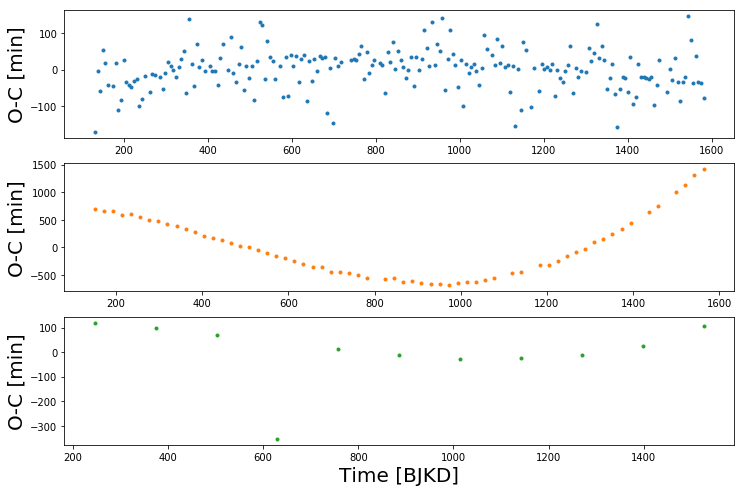

In [9]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
EPOCHS  = np.zeros(NPL)
PERIODS = np.zeros(NPL)

transit_inds = []
indep_transit_times = []
indep_ephemeris = []

FIXED_EPHEMERIS = []


for npl in range(NPL):
    # read in predetermined transit times
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    indep_transit_times.append(data_in[:,1])
    
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_fixed_ephemeris.txt'
    data_in  = np.genfromtxt(fname_in)
    
    FIXED_EPHEMERIS.append(data_in[:,1])
   

    # do a quick fit to get a linear ephemeris
    pfit = np.polyfit(transit_inds[npl], indep_transit_times[npl], 1)
    
    indep_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    EPOCHS[npl] = pfit[1]
    PERIODS[npl] = pfit[0]
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

# Determine TTV initialization settings

In [10]:
# get estimate of ttv amplitdue and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - FIXED_EPHEMERIS[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

In [11]:
# determine the time baseline
time_min = []
time_max = []

try:
    time_min.append(sc.time.min())
    time_max.append(sc.time.max()) 
except:
    pass


try:
    time_min.append(lc.time.min())
    time_max.append(lc.time.max())     
except:
    pass
    
    
TIME_START = np.min(time_min) - 0.5*PERIODS.max()
TIME_END   = np.max(time_max) + 0.5*PERIODS.max()


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

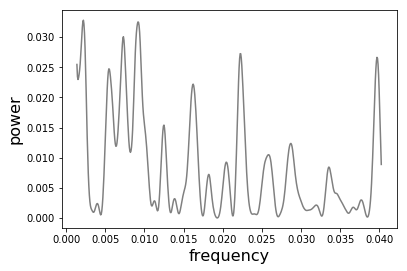

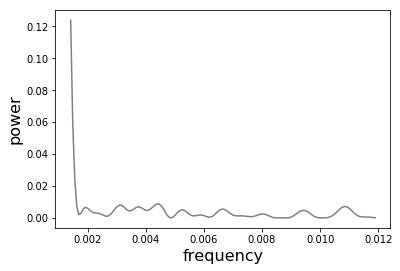

In [12]:
# here are the limits of the sinusoidal frequencies
fttv_min = (3/2)/(TIME_END-TIME_START)*np.ones(NPL)
fttv_max = 1/(4*PERIODS)


# here's the beat frequency (minimum delta_f detectable)
fbeat = 1/(TIME_END-TIME_START)

# Search the TTVs for significant frequencies
fttv1_ls = np.zeros(NPL)
fttv2_ls = np.zeros(NPL)
ttv_amps  = np.zeros(NPL)

for npl in range(NPL):
    xtime = indep_ephemeris[npl]
    yomc =  indep_transit_times[npl] - indep_ephemeris[npl]    
    
    ttv_amps[npl]  = astropy.stats.mad_std(yomc)
    
    # if there are enough points, search for significant frequencies
    if len(indep_ephemeris[npl]) > 15:
        xf, yf, freqs, faps = LS_estimator(xtime, yomc)                
        
        plt.figure()
        plt.plot(xf, yf, c='grey')
        
        for f in freqs:
            plt.axvline(f, c='C{0}'.format(npl))
        plt.xlabel('frequency', fontsize=16)
        plt.ylabel('power', fontsize=16)
        plt.show()
        
        
        if len(freqs) >= 2:
            fttv1_ls[npl] = freqs[0]
            fttv2_ls[npl] = freqs[1]
        
        elif len(freqs) == 1:
            fttv1_ls[npl] = freqs[0]
            fttv2_ls[npl] = None
            
            #if faps[0] <= 0.003:
            #    if 2*freqs[0] < fttv_max[npl]:
            #        fttv2_ls[npl] = 2*freqs[0]
            #    elif 0.5*freqs[0] > fttv_min[npl]:
            #        fttv2_ls[npl] = 0.5*freqs[0]
            #    else:
            #        fttv2_ls[npl] = None
                    
        else:
            fttv1_ls[npl] = None
            fttv2_ls[npl] = None
        
        
    # if there are not enough points, don't search for significant frequencies
    else:
        fttv1_ls[npl] = None
        fttv2_ls[npl] = None
        
        
for npl in range(NPL):
    if fttv1_ls[npl] is not None:
        ttv_amps[npl] *= np.sqrt(2)

In [13]:
# delta_f for one TTV frequency
log_df_mu = np.ones(NPL)*np.nan
log_df_sd = np.ones(NPL)*np.nan


# fplus, fminus for two TTV frequencies
fplus_init = np.ones(NPL)*np.nan
fminus_init = np.ones(NPL)*np.nan

fplus_lim  = np.ones((NPL,2))*np.nan
fminus_lim = np.ones((NPL,2))*np.nan

log_df_plus_mu = np.ones(NPL)*np.nan
log_df_plus_sd = np.ones(NPL)*np.nan

log_df_minus_mu = np.ones(NPL)*np.nan
log_df_minus_sd = np.ones(NPL)*np.nan


for npl in range(NPL):
    n_ttv_terms = 2 - (int(np.isnan(fttv1_ls[npl]))+int(np.isnan(fttv2_ls[npl])))
    
    if n_ttv_terms == 1:
        # transform to log_delta_f space
        df_loc = fttv1_ls[npl] - fttv_min[npl]
        df_scale = (fttv_max[npl]/fttv_min[npl])**0.25
        
        log_df_mu[npl] = np.log(df_loc)
        log_df_sd[npl] = np.log(df_scale)
        
        
    if n_ttv_terms == 2:
        # set limits and initial guesses for fplus & fminus
        fplus_lim[npl]  = 2*fttv_min[npl], 2*fttv_max[npl]
        fminus_lim[npl] = fbeat, fttv_max[npl]-fttv_min[npl] 
        
        fplus_init[npl]  = fttv1_ls[npl] + fttv2_ls[npl]
        fminus_init[npl] = np.abs(fttv1_ls[npl] - fttv2_ls[npl])
        
        
        # transform to log_delta_f space
        df_plus_loc = fplus_init[npl] - fplus_lim[npl,0]
        df_plus_scale = (fplus_lim[npl,1]/fplus_lim[npl,0])**0.25
        
        df_minus_loc = fminus_init[npl] - fminus_lim[npl,0]
        df_minus_scale = (fminus_lim[npl,1]/fminus_lim[npl,0])**0.25
        
        log_df_plus_mu[npl] = np.log(df_plus_loc)
        log_df_plus_sd[npl] = np.log(df_plus_scale)
        
        log_df_minus_mu[npl] = np.log(df_minus_loc)
        log_df_minus_sd[npl] = np.log(df_minus_scale)

# Set up GP

In [14]:
# Read in noise model GP priors
gp_percs = []

for z in range(4):
    try:
        fname_in = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_in) as infile:
            gp_percs.append(json.load(infile))

    except:
        gp_percs.append(None)

# Read in quarter-by-quarter variances
var_by_quarter = np.genfromtxt(NOISE_DIR + TARGET + '_var_by_quarter.txt')[:,1]

In [15]:
all_logSw4 = []
for z in range(4):
    try:
        perc = np.array(gp_percs[z]["percentiles"])
        
        all_logSw4.append(np.array(gp_percs[z]["logSw4"])[perc == 50.0][0])
        
    except:
        pass

In [16]:
gp_priors = []

for z in range(4):
    if gp_percs[z] is not None:
        gpi = {}

        for k in gp_percs[z].keys():
            if k != "percentiles":
                perc = np.array(gp_percs[z]['percentiles'])

                med = np.array(gp_percs[z][k])[perc == 50.0][0]
                err1 = np.array(gp_percs[z][k])[perc == 84.1][0]
                err2 = np.array(gp_percs[z][k])[perc == 15.9][0]

                dev = np.sqrt((err1-med)**2/2 + (err2-med)**2/2)

                gpi[k] = (med, dev)

        gp_priors.append(gpi)
        
    else:
        gpi = {}
        gpi['logSw4'] = (np.min(all_logSw4), 10.)
        gpi['logw0'] = (np.log(2*pi/DURS.max()), 10.)
        gpi['logQ'] = [1/np.sqrt(2)]
        
        gp_priors.append(gpi)

# Grab the relevant data and starting transit parameters

In [17]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [18]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  4 s



# Define Legendre polynomials

In [19]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl in range(NPL):    
    t.append(indep_ephemeris[npl])
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

# (3) Fit a transit model with both polynomial and sinusoidal components

In [20]:
print('\n(3) Fitting SINUSOIDAL TTV model')


(3) Fitting SINUSOIDAL TTV model


In [21]:
with pm.Model() as sin_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Bound(pm.Normal, lower=0)('Rstar', mu=RSTAR, sd=RSTAR_ERR)
    Mstar = pm.Bound(pm.Normal, lower=0)('Mstar', mu=MSTAR, sd=MSTAR_ERR)
    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(RADII), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    b    = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=IMPACTS, shape=NPL)

    
    # polynomial TTV parameters    
    C0 = pm.Normal('C0', mu=0.0, sd=ttv_amps, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=ttv_amps, shape=NPL)
    C2 = []
    C3 = []
    
    for npl in range(NPL):
        if len(transit_inds[npl]) > 7:
            C2.append(pm.Normal('C2_{0}'.format(npl), mu=0.0, sd=ttv_amps[npl], testval=0))
        else:
            C2.append(0.)
            
        if len(transit_inds[npl]) > 15:
            C3.append(pm.Normal('C3_{0}'.format(npl), mu=0.0, sd=ttv_amps[npl], testval=0))
        else:
            C3.append(0.)
    
    
    # sinusoidal TTV parameters
    log_df = []
    log_df_plus  = []
    log_df_minus = []
    
    fplus  = []
    fminus = []
    fttv1  = []
    fttv2  = []
    
    A1 = []
    B1 = []
    A2 = []
    B2 = []
    Amp = []
    
    for npl in range(NPL):
        # number of TTV frequencies to model
        n_ttv_terms = 2 - (int(np.isnan(fttv1_ls[npl]))+int(np.isnan(fttv2_ls[npl])))
        
        # zero frequencies
        if n_ttv_terms == 0:
            log_df.append(None)
            log_df_plus.append(None)
            log_df_minus.append(None)
            fplus.append(None)
            fminus.append(None)
            fttv1.append(0.)
            fttv2.append(0.)
            A1.append(0.)
            B1.append(0.)
            A2.append(0.)
            B2.append(0.)
            Amp.append(1.)
        
        # one frequency
        elif n_ttv_terms == 1:
            log_df_plus.append(None)
            log_df_minus.append(None)
            fplus.append(None)
            fminus.append(None)
            
            log_df.append(pm.Normal('log_df_{0}'.format(npl), mu=log_df_mu[npl], sd=log_df_sd[npl], testval=log_df_mu[npl]))
            fttv1.append(pm.Deterministic('fttv1_{0}'.format(npl), fttv_min[npl]+T.exp(log_df[npl])))
            fttv2.append(0.)
            A1.append(pm.Normal('A1_{0}'.format(npl), mu=0, sd=1))
            B1.append(pm.Normal('B1_{0}'.format(npl), mu=0, sd=1))
            A2.append(0.)
            B2.append(0.)
            
            Amp.append(ttv_amps[npl])
            
        # two frequencies
        if n_ttv_terms == 2:
            log_df.append(None)
            
            log_df_plus.append(pm.Normal('log_df_plus_{0}'.format(npl), mu=log_df_plus_mu[npl], \
                                         sd=log_df_plus_sd[npl], testval=log_df_plus_mu[npl]))
            
            log_df_minus.append(pm.Normal('log_df_minus_{0}'.format(npl), mu=log_df_minus_mu[npl], \
                                         sd=log_df_minus_sd[npl], testval=log_df_minus_mu[npl]))
            
            fplus.append(pm.Deterministic('fplus_{0}'.format(npl), fplus_lim[npl,0]+T.exp(log_df_plus[npl])))
            fminus.append(pm.Deterministic('fminus_{0}'.format(npl), fminus_lim[npl,0]+T.exp(log_df_minus[npl])))

            
            fttv1.append(pm.Deterministic('fttv1_{0}'.format(npl), 0.5*(fplus[npl]+fminus[npl])))
            fttv2.append(pm.Deterministic('fttv2_{0}'.format(npl), 0.5*(fplus[npl]-fminus[npl])))            
            
            A1.append(pm.Normal('A1_{0}'.format(npl), mu=0, sd=1, testval=0))
            B1.append(pm.Normal('B1_{0}'.format(npl), mu=0, sd=1, testval=0))
            A2.append(pm.Normal('A2_{0}'.format(npl), mu=0, sd=1, testval=0))
            B2.append(pm.Normal('B2_{0}'.format(npl), mu=0, sd=1, testval=0))
            
            Amp.append(ttv_amps[npl])
            
    
    # transit times
    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              FIXED_EPHEMERIS[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl] + \
                                              Amp[npl]*A1[npl]*T.sin(2*pi*fttv1[npl]*t[npl]) + \
                                              Amp[npl]*B1[npl]*T.cos(2*pi*fttv1[npl]*t[npl]) + \
                                              Amp[npl]*A2[npl]*T.sin(2*pi*fttv2[npl]*t[npl]) + \
                                              Amp[npl]*B2[npl]*T.cos(2*pi*fttv2[npl]*t[npl])))
                

    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    kernel = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]

        # here's the single low-frequency term
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]

        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]

        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
    
    
    # nuissance parameters (one mean flux; variance by quarter)
    flux0 = pm.Normal('flux0', mu=np.ones(nq), sd=np.sqrt(var_by_quarter)/4, shape=nq)
    logvar = pm.Normal('logvar', mu=np.log(var_by_quarter), sd=np.log(4)*np.ones(nq), shape=nq)
   

    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar[j])*T.ones(len(all_time[q])))


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        #gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

In [22]:
with sin_model:
    # Keplerian orbit parameters
    sin_map = exo.optimize(start=sin_model.test_point, vars=[flux0, logvar])   
    sin_map = exo.optimize(start=sin_map, vars=[C0, C1])    
    sin_map = exo.optimize(start=sin_map, vars=[b])
    sin_map = exo.optimize(start=sin_map, vars=[u, Mstar])
    
    # polynomial TTV parameters
    for npl in range(NPL):
        if np.isnan(fttv1_ls[npl]):
            try:
                sin_map = exo.optimize(start=sin_map, vars=[C2[npl], C3[npl]])
            except:
                try: sin_map = exo.optimize(start=sin_map, vars=[C2[npl]])
                except: pass
    
    # sinusoidal TTV parameters
    for npl in range(NPL):
        try:
            sin_map = exo.optimize(start=sin_map, vars=[A1[npl], B1[npl], A2[npl], B2[npl]])
        except:
            try:
                sin_map = exo.optimize(start=sin_map, vars=[A1[npl], B1[npl]])
            except:
                pass
        

    # all parameters
    #sin_map = exo.optimize(start=sin_map)

optimizing logp for variables: [logvar, flux0]
296it [00:17, 16.99it/s, logp=1.887172e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 118801.87940125335 -> 188717.2162078626
optimizing logp for variables: [C1, C0]
125it [00:07, 15.82it/s, logp=1.982498e+05]
message: Optimization terminated successfully.
logp: 188717.2162078626 -> 198249.79191435134
optimizing logp for variables: [b, logr, Rstar]
97it [00:07, 12.68it/s, logp=2.004966e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 198249.79191435134 -> 200496.60907595456
optimizing logp for variables: [Mstar, u]
73it [00:06, 11.61it/s, logp=2.004976e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 200496.60907595456 -> 200497.57196014936
optimizing logp for variables: [C3_0, C2_0]
80it [00:08,  9.31it/s, logp=2.005041e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 200497.57196014936 -> 200504.1375517774

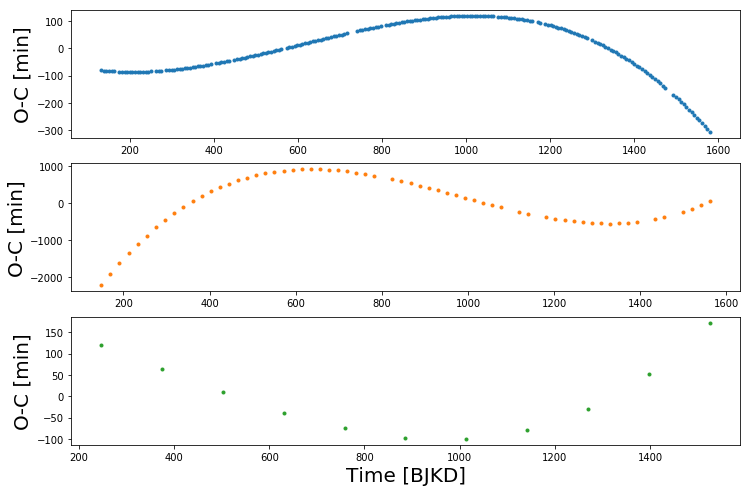

In [23]:
sin_transit_times = []
sin_ephemeris = []

for npl in range(NPL):
    sin_transit_times.append(sin_map['tts_{0}'.format(npl)])
    sin_ephemeris.append(sin_map['P'][npl]*transit_inds[npl] + sin_map['T0'][npl])
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl] - sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_sin.pdf', bbox_inches='tight')
plt.show()

In [26]:
sin_map

{'u_quadlimbdark__': array([ 0.30808963, -0.69206385]),
 'Rstar_lowerbound__': array(0.72384592),
 'Mstar_lowerbound__': array(-0.0282889),
 'logr_interval__': array([0.76821731, 0.70907311, 1.97614635]),
 'b_impact__': array([-2.0535159 ,  0.24500563,  0.63380728]),
 'C0': array([-0.03749188, -1.20126651,  0.05483811]),
 'C1': array([-0.46587217, -0.33475465, -0.10437385]),
 'C2_0': array(-0.16550055),
 'C3_0': array(-0.10548616),
 'C2_1': array(-1.93182581),
 'C3_1': array(0.89010837),
 'C2_2': array(0.08930229),
 'logSw4_0': array(-1.43956089),
 'logw0_0': array(5.48920208),
 'logQ_0': array(0.34388176),
 'logSw4_1': array(-2.40179222),
 'logw0_1': array(2.34350787),
 'logSw4_2': array(-2.40179222),
 'logw0_2': array(2.34350787),
 'logSw4_3': array(-2.40179222),
 'logw0_3': array(5.32739452),
 'logQ_3': array(0.90570815),
 'flux0': array([1.0000007 , 1.00000046, 1.00021743, 1.00014337, 1.00000162,
        1.00000146, 1.00026213, 1.00007217, 1.00000104, 1.00000214,
        1.00016127

### (3) Sample from posteriors for POLYNOMIAL + SINUSOID transit times

In [ ]:
with sin_model:
    sin_trace = pm.sample(tune=1000, draws=500, start=sin_map, chains=2, \
                      step=exo.get_dense_nuts_step(target_accept=0.9))

In [ ]:
# select which variables to save (don't save full GP or model traces or "under the hood" variables)
sin_map_keys = list(sin_map.keys())
sin_varnames = []

for i, smk in enumerate(sin_map_keys):
    skip = ("gp_pred" in smk) + ("model_flux" in smk) + ("__" in smk)

    if skip == False:
        sin_varnames.append(smk)

In [ ]:
sin_hdulist = io.trace_to_hdulist(sin_trace, sin_varnames, TARGET)
sin_hdulist.writeto(TRACE_DIR + TARGET + '_sin_ttvs.fits', overwrite=True)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))